In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Term Structure of Interest Rates

In [33]:
def phi_t(a, b, lamda, t):
    phit = a + b*(((1-np.exp(-lamda*t))/(lamda*t))-np.exp(-lamda*t))
    return phit

def Euler_sch(a, b, sigma, alpha, beta, eta, lamda, Nsim, Ntime, x_0, y_0):
    x = np.zeros((Nsim, Ntime+1))
    y = np.zeros((Nsim, Ntime+1))
    r = np.zeros((Nsim, Ntime+1))
    phi = np.zeros((Nsim, Ntime+1))
    phi[:,0] = a
    r[:,0] = a + x_0 + y_0
    x[:,0] = x_0
    y[:,0] = y_0
    dt = 1/252
    t = 0
    # Set initial x_0, y_0
    for i in range(Ntime):
        Z_1 = np.random.standard_normal(Nsim)
        Z_2 = np.random.standard_normal(Nsim)
        t = (i+1)*dt
        x[:,i+1] = x[:,i] - alpha*x[:,i]*dt + sigma*np.sqrt(dt)*Z_1
        y[:,i+1] = y[:,i] - beta*y[:,i]*dt + eta*np.sqrt(dt)*Z_2
        phi[:,i+1] = phi_t(a,b,lamda,t)
        r[:,i+1]= phi[:,i+1] + x[:,i+1] +y[:,i+1]
    Pt0 = np.mean(np.exp(-np.sum(r, axis=1)*dt))
    return x,y,r,Pt0

Set basic parameters

In [34]:
x_0 = -0.005
y_0 = 0.005
alpha = 3
sigma = 0.01
beta = 1
eta = 0.005
a = 0.02
b = 0.05
lamda = 0.75
Ntime = 252*10
Nsim = 1000


x = np.zeros((Nsim, Ntime+1))
y = np.zeros((Nsim, Ntime+1))
r = np.zeros((Nsim, Ntime+1))

x,y,r,pt0 = Euler_sch(a, b, sigma, alpha, beta, eta, lamda, Nsim, Ntime, x_0, y_0)



0.7333741250801424


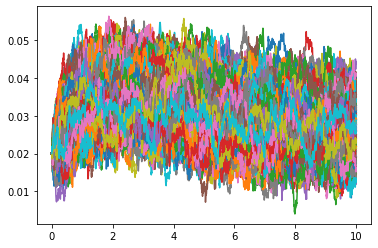

In [38]:
print(pt0)
t = np.linspace(0,10,Ntime+1)
for i in range(Nsim):
    plt.plot(t,r[i,:])
plt.show()

Q3 Use 10000 paths to obtain MC estimate of bond yields

In [22]:
# Simulation Method

def Yields_mat(a, b, sigma, alpha, beta, eta, lamda, Nsim, T, x_0, y_0):
    Pt0 = []
    yt = []
    #Ntime = T*12*21
    #dt = 1/252
    #r = np.zeros((Nsim, Ntime+1))
    #r = Euler_sch(a, b, sigma, alpha, beta, eta, lamda, Nsim,Ntime, x_0, y_0)[2]
    #print(r)
    for i in range(12*T):
        length = (i+1)*21
        #data = r[:,length]
       # print(data)
       # pt0 = np.mean(np.sum(data,axis=1))*dt
        pt0 = Euler_sch(a, b, sigma, alpha, beta, eta, lamda, Nsim,Ntime, x_0, y_0)[3]
        Pt0 += [pt0]
        yt += [-np.log(pt0)/((i+1)*21)]
    
    return yt,Pt0
    


# Analytical Method


In [23]:
x_0 = -0.005
y_0 = 0.005
alpha = 3
sigma = 0.01
beta = 1
eta = 0.005
a = 0.02
b = 0.05
lamda = 0.75
T = 1
Nsim = 10000
yt,Pt = Yields_mat(a, b, sigma, alpha, beta, eta, lamda, Nsim,T, x_0, y_0)


In [24]:
Pt

[0.7342010385296516,
 0.7337429348077016,
 0.7340191558251034,
 0.7338492118473813,
 0.7337473426418549,
 0.7336756141730357,
 0.7339151582001197,
 0.7340440660261957,
 0.7337431406345553,
 0.7340447185553829,
 0.7339361113819237,
 0.7338142458656743]

In [25]:
yt

[0.014712971115013991,
 0.007371346113532553,
 0.004908256394504766,
 0.0036839488681237784,
 0.002948481232941451,
 0.002457843576163154,
 0.002104502349195086,
 0.0018403941470931265,
 0.0016380754299053226,
 0.001472311084576508,
 0.0013391051769262843,
 0.0012281720373936082]

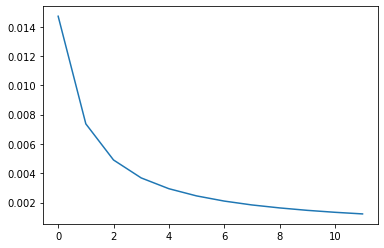

In [26]:
plt.plot(yt)

     |████████████████████████████████| 15.4 MB 222 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
